# Лабораторная работа №3. RNN в обработке текстов. Часть 1.

## Импорт библиотек

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from collections import Counter





from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer


## Задание 1. Решите задачу расшифровки сообщения с помощью RNN.
Представьте, что вам даны сообщения, зашифрованные с помощью шифра Цезаря, являющимся одним из самый простых шифров, в криптографии.
Шифр цезаря работает следующим образом: каждая буква исходного алфавита сдвигается на K символов вправо:
Пусть нам дано сообщение: message="RNN IS NOT AI", тогда наше шифрование выполняющиеся по правилу f, с K=2, даст нам результат: f(message, K) = TPPAKUAPQVACK.
Для удобства можно взять символы только одного регистра в нашей имплементации, и сказать, что все буквы не английского алфавита будут отмечены как прочерк "-"

In [ ]:
vocab = [char for char in ' -ABCDEFGHIJKLMNOPQRSTUVWXYZ']

In [ ]:
def encrypt(text, key):
    """Returns the encrypted form of 'text'."""
    encrypted_chars = [ vocab[(vocab.index(char) + key) % len(vocab)]  for char in text]
    encrypted_text = ''.join(encrypted_chars)
    return encrypted_text

key = 2
print(encrypt('RNN IS NOT AI', key))

TPPAKUAPQVACK


In [ ]:
num_examples = 256 # размер датасета
seq_len = 18 # максимальная длина строки


def encrypted_dataset(dataset_len, k):
    """
    Return: List(Tuple(Tensor encrypted, Tensor source))
    """
    dataset = []
    for x in range(dataset_len):
        random_message  = ''.join([random.choice(vocab) for x in range(seq_len)])
        encrypt_random_message = encrypt(''.join(random_message), k)

        trg = [vocab.index(x) for x in random_message]
        src = [vocab.index(x) for x in encrypt_random_message]

        dataset.append([torch.tensor(src), torch.tensor(trg)])
    return dataset

In [ ]:
class Decipher(nn.Module):
    # двухслойная простая RNN с размером входа embedding_dim и размером скрытого состояния hidden_dim.
    def __init__(self, vocab_size, embedding_dim, hidden_dim,
                 rnn_type='simple'):
        """
        :params: int vocab_size
        :params: int embedding_dim
        :params
        """
        super(Decipher, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == 'simple':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = 2)

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.initial_hidden = torch.zeros(2, 1, hidden_dim)


    def forward(self, cipher):
        # CHECK INPUT SIZE
        # Unsqueeze 1 dimension for batches
        embd_x = self.embed(cipher).unsqueeze(1)
        out_rnn, hidden = self.rnn(embd_x, self.initial_hidden)
        # Apply the affine transform and transpose output in appropriate way
        # because you want to get the softmax on vocabulary dimension
        # in order to get probability of every letter
        return self.fc(out_rnn).transpose(1, 2)


In [ ]:
# определим параметры нашей модели
embedding_dim = 100
hidden_dim = 10
vocab_size = len(vocab)
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
model = Decipher(vocab_size, embedding_dim, hidden_dim)

# Инициализируйте оптимизатор: рекомендуется Adam
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

num_epochs = 10

In [ ]:
k = 10
for x in range(num_epochs):
    print('Epoch: {}'.format(x))
    for encrypted, original in encrypted_dataset(num_examples, k):

        scores = model(encrypted)
        original = original.unsqueeze(1)
        # Calculate loss
        loss = criterion(scores, original)
        # Zero grads
        optimizer.zero_grad()
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
    print('Loss: {:6.4f}'.format(loss.item()))

    with torch.no_grad():
        matches, total = 0, 0
        for encrypted, original in encrypted_dataset(num_examples, k):
            # Compute a softmax over the outputs
            predictions = F.softmax(model(encrypted), 1)
            # Choose the character with the maximum probability (greedy decoding)
            _, batch_out = predictions.max(dim=1)
            # Remove batch
            batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total
        print('Accuracy: {:4.2f}%'.format(accuracy * 100))

Epoch: 0
Loss: 2.1745
Accuracy: 70.23%
Epoch: 1
Loss: 1.3209
Accuracy: 100.00%
Epoch: 2
Loss: 0.7208
Accuracy: 100.00%
Epoch: 3
Loss: 0.4465
Accuracy: 100.00%
Epoch: 4
Loss: 0.2792
Accuracy: 100.00%
Epoch: 5
Loss: 0.2042
Accuracy: 100.00%
Epoch: 6
Loss: 0.1532
Accuracy: 100.00%
Epoch: 7
Loss: 0.1224
Accuracy: 100.00%
Epoch: 8
Loss: 0.0913
Accuracy: 100.00%
Epoch: 9
Loss: 0.0641
Accuracy: 100.00%


## Задание 2. Примените RNN к классификации текстов из лабораторной работы №1 (на несбалансированных и балансированных классах). Сравните результаты с классическими методами машинного обучения. Сделайте выводы!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/lem_500kdata.csv', index_col=0)

In [ ]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#### Несбалансированных классы

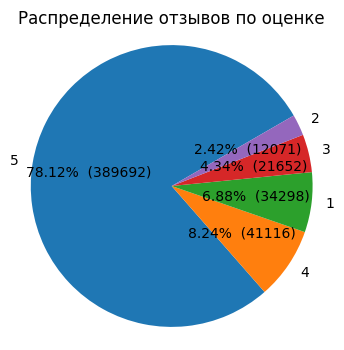

In [ ]:
rating_counts = df['rating'].value_counts()



plt.figure(figsize=(4, 4))
plt.pie(rating_counts, labels=rating_counts.index, autopct= make_autopct(rating_counts) , startangle=30)
plt.axis('equal')
plt.title('Распределение отзывов по оценке')

plt.show()

In [ ]:
df_unbalanced = df

#### Cбалансированных классы

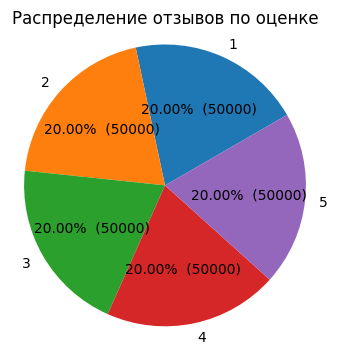

In [ ]:
class_1 = df[df['rating'] == 1]
class_2 = df[df['rating'] == 2]
class_3 = df[df['rating'] == 3]
class_4 = df[df['rating'] == 4]
class_5 = df[df['rating'] == 5]


size = 50000



class_1_oversampled = resample(class_1, replace=True, n_samples=size)
class_2_oversampled = resample(class_2, replace=True, n_samples=size)
class_3_oversampled = resample(class_3, replace=True, n_samples=size)
class_4_oversampled = resample(class_4, replace=True, n_samples=size)
class_5_undersampled = resample(class_5, replace=False, n_samples=size)


df_balanced = pd.concat([class_1_oversampled, class_2_oversampled, class_3_oversampled, class_4_oversampled, class_5_undersampled])


rating_counts = df_balanced['rating'].value_counts()


plt.figure(figsize=(4, 4))
plt.pie(rating_counts, labels=rating_counts.index, autopct= make_autopct(rating_counts) , startangle=30)
plt.axis('equal')
plt.title('Распределение отзывов по оценке')

plt.show()





In [ ]:
df_balanced.dropna(inplace = True)
df_balanced

,rating,text
486602,1,прислать день семьёйникий стойка нести присест...
154727,1,семья заведение сегодня брат брать бургер пара...
262947,1,вызывать мастер тк домофон работать озвучить д...
152820,1,хотеть тратить свой время отзыв позвонить сдер...
123477,1,толпа народ нудный ожидание очередь квалификац...
...,...,...
365356,5,зимний марафон час первый россия круто поддерж...
274620,5,местный сеть гипермаркет который отличный выбо...
111070,5,исправлять прикус эйлайнер музакаев удалять ку...
63834,5,очень вкусно акция скачтвать приложение нравит...


In [ ]:
df_unbalanced.dropna(inplace = True)
df_unbalanced

,rating,text
0,3,московский квартал шумно лето ночь дикий гонка...
1,5,замечательный сеть магазин общий хороший ассор...
2,1,знать смутить коготь дать правило удивить хоте...
3,4,хороший условие аренда дружелюбный персонално ...
4,5,топ мастер ангелина топ смысл немного волноват...
...,...,...
499994,5,хороший способ избежать автобусный пытка элект...
499995,4,охрана кривая добрый дверь закрываться автомат...
499996,4,сравнение многий современный платформа эпоха с...
499998,5,семья отличный место рекомендовать это настоящ...


### Создание словаря

In [ ]:
def yield_tokens(dataset):
    for line in dataset['text']:
        yield line.strip().split()

vocab_balanced = build_vocab_from_iterator(yield_tokens(df_balanced), specials=["<unk>", "<pad>"], min_freq = 5)
vocab_unbalanced = build_vocab_from_iterator(yield_tokens(df_unbalanced), specials=["<unk>", "<pad>"], min_freq = 5)

In [ ]:
vocab_balanced.get_stoi()['тёмный']

1714

In [ ]:
vocab_balanced.get_stoi()

{'ясень': 50780,
 'ярушко': 50778,
 'ярошенко': 50777,
 'япошка': 50774,
 'яодно': 50773,
 'янтыками': 50772,
 'янковский': 50771,
 'яндексдоставка': 50769,
 'ямз': 50765,
 'ягермейстер': 50759,
 'явлениепсихолог': 50758,
 'яблокамиоказаться': 50757,
 'ютуб': 50755,
 'юрьевпольский': 50754,
 'юра': 50752,
 'юма': 50751,
 'ювелирно': 50746,
 'этохороший': 50743,
 'этофиаско': 50742,
 'этомсегодня': 50738,
 'этомпродавец': 50737,
 'этомпожаловать': 50736,
 'этогон': 50733,
 'этоговаш': 50732,
 'этнографический': 50728,
 'этито': 50727,
 'этасамый': 50726,
 'этажтак': 50725,
 'этажлифт': 50724,
 'этажеэтый': 50723,
 'этажевторое': 50721,
 'эстерхазить': 50719,
 'эсли': 50717,
 'эскалаторный': 50714,
 'эпиляциювсе': 50712,
 'эпидти': 50710,
 'энцефалит': 50708,
 'энтерит': 50707,
 'энннннный': 50706,
 'эндшпиль': 50703,
 'эльнара': 50695,
 'эльзат': 50694,
 'электротранспорт': 50691,
 'электроскладываниемтогда': 50690,
 'электрогитара': 50687,
 'электра': 50685,
 'экстримальный': 50684,
 '

In [ ]:
word2ind_balanced = vocab_balanced.get_stoi()
ind2word_balanced = {index : word for word , index in vocab_balanced.get_stoi().items()}

word2ind_unbalanced = vocab_unbalanced.get_stoi()
ind2wordb_unbalanced = {index : word for word , index in vocab_unbalanced.get_stoi().items()}

Создал словари для удобного перевода слова в индекс и индекс в слово

In [ ]:
ind2word_balanced[1]

'<pad>'

In [ ]:
len(vocab_balanced), len(vocab_unbalanced)

(50783, 47083)

### Device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Data Loader

In [ ]:
class WordDatasetBalanced:
    def __init__(self, text, label):
      self.text = text
      self.label = label

      self.unk_id = word2ind_balanced['<unk>']
      self.pad_id = word2ind_balanced['<pad>']

    def __getitem__(self, index):
      processed_text = self.text[index].split() # already prepross only split()
      tokenized_sentence = [
            word2ind_balanced.get(word, self.unk_id) for word in processed_text
            ]

      train_sample = {
            "text": tokenized_sentence,
            "label": self.label[index]
        }

      return train_sample

    def __len__(self) -> int:
        return len(self.text)

In [ ]:
class WordDatasetUnBalanced:
    def __init__(self, text, label):
      self.text = text
      self.label = label

      self.unk_id = word2ind_unbalanced['<unk>']
      self.pad_id = word2ind_unbalanced['<pad>']

    def __getitem__(self, index):
      processed_text = self.text[index].split() # already prepross only split()
      tokenized_sentence = [
            word2ind_unbalanced.get(word, self.unk_id) for word in processed_text
            ]

      train_sample = {
            "text": tokenized_sentence,
            "label": self.label[index]
        }

      return train_sample

    def __len__(self) -> int:
        return len(self.text)

In [ ]:
def collate_fn_with_padding(input_batch, pad_id= 1 , max_len=256):
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]

        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label']  for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
text_balanced = df_balanced['text'].values
label_balanced = df_balanced['rating'].values - 1

text_unbalanced = df_unbalanced['text'].values
label_unbalanced = df_unbalanced['rating'].values - 1

In [ ]:
dataset_balanced = WordDatasetBalanced(text_balanced, label_balanced)

dataset_unbalanced = WordDatasetUnBalanced(text_unbalanced, label_unbalanced)


train_size_balanced = int(0.8 * len(dataset_balanced))
test_size_balanced = len(dataset_balanced) - train_size_balanced

train_size_unbalanced = int(0.8 * len(dataset_unbalanced))
test_size_unbalanced = len(dataset_unbalanced) - train_size_unbalanced


batch_size_train = 128
batch_size_test = 1000


train_dataset_balanced, test_dataset_balanced = torch.utils.data.random_split(dataset_balanced, [train_size_balanced, test_size_balanced])


train_dataset_balanced = DataLoader(train_dataset_balanced, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size_train)
test_dataset_balanced = DataLoader(test_dataset_balanced, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size_test)


train_dataset_unbalanced, test_dataset_unbalanced = torch.utils.data.random_split(dataset_unbalanced, [train_size_unbalanced, test_size_unbalanced])


train_dataset_unbalanced = DataLoader(train_dataset_unbalanced, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size_train)
test_dataset_unbalanced = DataLoader(test_dataset_unbalanced, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size_test)


In [ ]:
len(train_dataset_balanced.dataset) , len(train_dataset_unbalanced.dataset)

(199994, 399045)

In [ ]:
train_dataset_balanced.dataset[4]['text']

[132,
 3771,
 53,
 69,
 10,
 502,
 9,
 1391,
 1895,
 59,
 693,
 56,
 42,
 278,
 6497,
 278,
 2598,
 302,
 541,
 868,
 19,
 4420,
 147]

### Модель

In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes = 5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 128)
        self.projection = nn.Linear(128, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(0.25)


    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = output.max(dim=1)[0] #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Функция обучение модели

In [ ]:
from tqdm.auto import tqdm


def train(model, optimizer, criterion, n_epochs, train_loader, test_loader):

    loss_train = []
    accuracy_train = []

    for epoch in range(n_epochs):
        model.train()  # для трейна модели ставим ее в train()
        for batch in tqdm(train_loader, desc=f'Training epoch {epoch + 1}:'):
          texts = batch['input_ids']
          labels = batch['label']
          output = model(texts)
          loss = criterion(output, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        model.eval()  # для теста модели ставим ее в eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for texts, labels in test_loader:

              texts = batch['input_ids']
              labels = batch['label']
              output = model(texts)
              _, predicted = torch.max(output.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        accuracy_train.append(test_accuracy)

        print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch + 1, n_epochs, loss.item(), test_accuracy * 100))
        loss_train.append(loss.item())

## Обучение модели на сбалансированных данных

In [ ]:
input_dim = len(vocab_balanced)
hidden_dim = 256
output_dim = 2
n_epoch = 10


model = RNN(hidden_dim=256, vocab_size=len(vocab_balanced)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss(ignore_index= 1)


train(model, optimizer, criterion, n_epoch, train_dataset_balanced, test_dataset_balanced)

Training epoch 1::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.9802, Test Accuracy: 55.17%


Training epoch 2::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.6514, Test Accuracy: 70.69%


Training epoch 3::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.7830, Test Accuracy: 58.62%


Training epoch 4::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.5841, Test Accuracy: 68.97%


Training epoch 5::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.7063, Test Accuracy: 68.97%


Training epoch 6::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.6269, Test Accuracy: 67.24%


Training epoch 7::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.4823, Test Accuracy: 74.14%


Training epoch 8::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.3801, Test Accuracy: 72.41%


Training epoch 9::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.5275, Test Accuracy: 72.41%


Training epoch 10::   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.4754, Test Accuracy: 74.14%


In [ ]:
input_dim = len(vocab_unbalanced)
hidden_dim = 256
output_dim = 2
n_epoch = 10


model = RNN(hidden_dim=256, vocab_size=len(vocab_unbalanced)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss(ignore_index= 1)


train(model, optimizer, criterion, n_epoch, train_dataset_unbalanced, test_dataset_unbalanced)

Training epoch 1::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3432, Test Accuracy: 84.06%


Training epoch 2::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.3725, Test Accuracy: 88.41%


Training epoch 3::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.4957, Test Accuracy: 82.61%


Training epoch 4::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.3735, Test Accuracy: 81.16%


Training epoch 5::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.5171, Test Accuracy: 78.26%


Training epoch 6::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.3352, Test Accuracy: 88.41%


Training epoch 7::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.4839, Test Accuracy: 81.16%


Training epoch 8::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.2851, Test Accuracy: 86.96%


Training epoch 9::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.2298, Test Accuracy: 86.96%


Training epoch 10::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.2258, Test Accuracy: 85.51%


Вывод: могу сказать что обучение с rnn дает больше возможностей и лучше обучается на отзывах, так как запоминает контекст. Классические методы обучения не сравнятся. Лучше обучилось несбалансированной. Так как тест тоже несбалансированный.

In [ ]:
input_dim = len(vocab_unbalanced)
embedding_dim = 100
hidden_dim = 512
output_dim = 2
n_epoch = 10


model = RNN(hidden_dim=256, vocab_size=len(vocab_unbalanced)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss(ignore_index= 1)


train(model, optimizer, criterion, n_epoch, train_dataset_unbalanced, test_dataset_balanced)

Training epoch 1::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2447, Test Accuracy: 92.75%


Training epoch 2::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.5901, Test Accuracy: 82.61%


Training epoch 3::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.4845, Test Accuracy: 81.16%


Training epoch 4::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.5919, Test Accuracy: 78.26%


Training epoch 5::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.3654, Test Accuracy: 84.06%


Training epoch 6::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.4415, Test Accuracy: 81.16%


Training epoch 7::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.2696, Test Accuracy: 91.30%


Training epoch 8::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.4039, Test Accuracy: 85.51%


Training epoch 9::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.3094, Test Accuracy: 85.51%


Training epoch 10::   0%|          | 0/3118 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.2849, Test Accuracy: 91.30%


Вывод 2: как мы видим на несбалансированном датасете и даже тестом на сбалансированным данных работает отлично. То есть Rnn - хорошо работает на любых данных.

## Задание 3. Для настоящего корпуса собраний сочинений Федора Михайловича Достоевского сделайте следующие задания:

### Сколько слов и предложений в датасете?

In [ ]:
import re

from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
with open('/content/drive/MyDrive/NLP/dostoevsky.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [ ]:
text = text.lower()
sent_text = sent_tokenize(text, language="russian")
print("Колличество предложений:" , len(sent_text))

text = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
tokenized_text = word_tokenize(text, language='russian')
print("Колличество слов:" , len(tokenized_text))




Колличество предложений: 121826
Колличество слов: 1824150


### Каковы частоты для слов «бесы», «семья», «брат».

In [ ]:
counter_text = Counter(tokenized_text)
print("Частота слова «бесы» " , round(counter_text['бесы'] / len(tokenized_text),5))
print("Частота слова «семья» " ,round(counter_text['семья'] / len(tokenized_text),5))
print("Частота слова «брат» " , round(counter_text['брат'] / len(tokenized_text),5))

Частота слова «бесы»  1e-05
Частота слова «семья»  1e-05
Частота слова «брат»  0.00031


### Сгенерируйте текст, который состоит из слов с вероятностями появления от 0. 85 до 0.95 и итоговое предложение состоит из 10 слов.

# Часть 2

## Задание 1. На основе минимум 2 коллекций предобученных эмбеддингов для русского языка постройте эмбеддинги для корпуса собраний сочинений Федора Михайловича Достоевского. Сделайте экспертную оценку построенной модели на примерах (униграммы и биграммы).
Примеры коллекций: https://natasha.github.io/navec/; https://rusvectores.org/ru/models/)

## Navec

In [ ]:
pip install navec slovnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
from nltk import word_tokenize, bigrams

from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import torch
from navec import Navec
from slovnet.model.emb import NavecEmbedding

path = '/content/drive/MyDrive/NLP/navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
navec = Navec.load(path)  # ~1 sec, ~100MB RAM

# words = ['навек', '<unk>', '<pad>']
# ids = [navec.vocab[_] for _ in words]

# emb = NavecEmbedding(navec)
# input = torch.tensor(ids)

In [ ]:
with open('/content/drive/MyDrive/NLP/dostoevsky.txt', 'r', encoding='utf-8') as file:
    text = file.read()


text = text.lower()
text = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)

unigram_tokens = word_tokenize(text, language='russian')
bigram_tokens = list(bigrams(unigram_tokens))

In [ ]:
bigram_tokens[0],bigram_tokens[1]

(('федор', 'михайлович'), ('михайлович', 'достоевский'))

In [ ]:
unigram_map = {}
for word in unigram_tokens:
    if word in navec:
        unigram_map[word] = navec.get(word)

bigram_map = {}
for bigram in bigram_tokens:
    word1, word2 = bigram
    if word1 in navec and word2 in navec:
        bigram_map[bigram] = [navec.get(word1), navec.get(word2)]

### Проверка unigram

In [ ]:
input_word = 'миша'
target_vector = unigram_map[input_word]
similarity_vectors = []


for word, vector in unigram_map.items():
  if word != input_word:
    similarity_vectors.append([word, cosine_similarity([target_vector], [vector])[0][0]])

In [ ]:
similarity_vectors = sorted(similarity_vectors, key = lambda x: x[1], reverse=True)

print("Близкие слова к слову ", input_word)
for word, similarity in similarity_vectors[:10]:
    print(f'{word}: {similarity}')

Близкие слова к слову  миша
коля: 0.8531296253204346
саша: 0.8510871529579163
вася: 0.8405131101608276
костя: 0.8329855799674988
володя: 0.8277865052223206
петя: 0.8182589411735535
сережа: 0.8178241848945618
ваня: 0.8156984448432922
гриша: 0.8142248392105103
митя: 0.799966037273407


### Проверка bigram

In [ ]:
list(bigram_map.keys())[102]

('подымаю', 'глаза')

In [ ]:
from tqdm.auto import tqdm

input_words = ('подымаю', 'глаза')
target_vector = bigram_map.get(input_words)
similarity_vectors = []


for bigram, vectors in tqdm(bigram_map.items()) :
  if bigram != input_words:
    cos = cosine_similarity([sum(target_vector)], [sum(vectors)])[0][0]
    similarity_vectors.append([bigram, cosine_similarity([sum(target_vector)], [sum(vectors)])[0][0]])

  0%|          | 0/815480 [00:00<?, ?it/s]

In [ ]:
similarity_vectors = sorted(similarity_vectors, key = lambda x: x[1], reverse=True)

print("Близкие bigram'а к bigram'e ", input_word)
for word, similarity in similarity_vectors[:10]:
    print(f'{word}: {similarity}')

Близкие bigram'а к bigram'e  миша
('подымая', 'глаза'): 0.7564176917076111
('потупленные', 'глаза'): 0.7472983598709106
('раскрываю', 'глаза'): 0.7317407131195068
('глаза', 'опустишь'): 0.7262037992477417
('опускал', 'глаза'): 0.7224451899528503
('опустит', 'глаза'): 0.7216630578041077
('закрываю', 'глаза'): 0.7189372777938843
('подымаю', 'нос'): 0.7187379002571106
('подняв', 'глаза'): 0.716677725315094
('потупил', 'глаза'): 0.7122519612312317


### Визуализация

In [ ]:
counter = Counter(unigram_tokens)

In [ ]:
n_words = 1000
words = sorted(set(unigram_tokens),
               key=lambda word: counter[word],
               reverse=True)[:n_words]

print(words[::10])

['и', 'а', 'меня', 'еще', 'был', 'уж', 'него', 'тогда', 'этот', 'надо', 'нас', 'впрочем', 'кто', 'кажется', 'сейчас', 'своей', 'слишком', 'сердце', 'сами', 'знал', 'иногда', 'другой', 'особенно', 'мое', 'моя', 'людей', 'вчера', 'таким', 'ибо', 'несмотря', 'вопрос', 'могла', 'которого', 'которой', 'самой', 'взял', 'таких', 'ваше', 'быстро', 'решительно', 'ясно', 'самым', 'александровна', 'дом', 'таком', 'позвольте', 'петровна', 'этому', 'женщина', 'свете', 'варвара', 'ответил', 'наташа', 'самые', 'вероятно', 'моем', 'дядя', 'сильно', 'показалось', 'алексей', 'разговор', 'глазах', 'кому', 'чрез', 'лизавета', 'встал', 'должны', 'всякого', 'решился', 'пристально', 'взять', 'разумихин', 'закричал', 'конец', 'спросила', 'ганя', 'улыбкой', 'вслед', 'катя', 'женщины', 'павловича', 'высшей', 'смотрела', 'превосходительство', 'приехал', 'ответ', 'шел', 'дать', 'чувствовал', 'шесть', 'удивлением', 'петербург', 'прощайте', 'народа', 'будь', 'пойдет', 'вскричала', 'усмехнулся', 'капитан', 'новый']


In [ ]:
words_to_visualize = list(unigram_map.keys())
embeddings_to_visualize = list(unigram_map.values())

embeddings_np = np.array(embeddings_to_visualize)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings_np)
word_vectors_pca = pca.transform(embeddings_np)

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(word_vectors_pca)
word_vectors_pca = ss.transform(word_vectors_pca)

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()
from IPython.display import display

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig


draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

figure(id='p1184', ...)

## Rusvectores

In [ ]:
from gensim.models import KeyedVectors
import pymorphy2

In [ ]:
model_path = '/content/drive/MyDrive/NLP/model.bin'

model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
morph = pymorphy2.MorphAnalyzer()


with open('/content/drive/MyDrive/NLP/dostoevsky.txt', 'r', encoding='utf-8') as file:
    text = file.read()


text = text.lower()
text = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)

unigram_tokens = word_tokenize(text, language='russian')


new_words = []

for word in unigram_tokens:
    parsed_word = morph.parse(word)[0]
    if parsed_word.tag.POS:
        new_words.append(word+'_'+str(parsed_word.tag.POS))

bigram_tokens = list(bigrams(new_words))
unigram_tokens = new_words

In [ ]:
unigram_map = {}
for word in unigram_tokens:
    if word in model:
        unigram_map[word] = model.get_vector(word)

bigram_map = {}
for bigram in bigram_tokens:
    word1, word2 = bigram
    if word1 in model and word2 in model:
        bigram_map[bigram] = [model.get_vector(word1), model.get_vector(word2)]

In [ ]:
unigram_map['шелк_NOUN']

array([-0.46864402, -0.6255685 , -2.0718644 , -0.20263283,  0.55193824,
        1.133297  ,  0.7278876 ,  3.13892   ,  0.39580137, -0.20978   ,
        1.3031062 , -2.728743  ,  1.0433098 ,  0.39068696,  1.409493  ,
        0.33143574,  0.03353212,  1.115272  , -0.46276763, -0.14781865,
       -0.07587393, -1.367159  ,  2.5237858 , -2.4057271 , -0.5889576 ,
        1.710713  ,  1.0927693 ,  2.0557    , -0.28677624, -2.0410397 ,
        3.2073205 ,  1.5801582 ,  3.1933885 , -2.1780338 ,  0.9925145 ,
        0.12072785,  0.63395786,  0.8319073 ,  1.4089948 , -0.7296558 ,
       -0.4877871 , -2.692961  ,  1.3093259 ,  0.9511502 , -0.5065424 ,
       -0.5922212 , -0.2703694 , -0.6899737 ,  0.08478723,  1.1747861 ,
        0.61135256, -0.532909  ,  1.5857825 , -0.37409908,  1.2390558 ,
       -1.1445042 ,  0.20016037,  0.10359961,  0.8398143 ,  1.5045134 ,
       -1.2822707 , -1.0993097 ,  1.9750787 ,  0.18003179, -0.26339763,
        0.69803566, -0.95589125,  1.6710801 ,  2.2904527 , -2.26

### Проверка unigram

In [ ]:
input_word = 'миша_NOUN'
target_vector = unigram_map[input_word]
similarity_vectors = []


for word, vector in unigram_map.items():
  if word != input_word:
    similarity_vectors.append([word, cosine_similarity([target_vector], [vector])[0][0]])

In [ ]:
similarity_vectors = sorted(similarity_vectors, key = lambda x: x[1], reverse=True)

print("Близкие слова к слову ", input_word)
for word, similarity in similarity_vectors[:10]:
    print(f'{word}: {similarity}')

Близкие слова к слову  миша_NOUN
даша_NOUN: 0.5659310817718506
ниночка_NOUN: 0.5537696480751038
зиночка_NOUN: 0.5446333289146423
катька_NOUN: 0.5369653701782227
анютка_NOUN: 0.5322409272193909
леночка_NOUN: 0.5285024046897888
леша_NOUN: 0.5255159139633179
катя_NOUN: 0.5219506025314331
клавдия_NOUN: 0.5189082622528076
полина_NOUN: 0.5173929333686829


### Проверка bigram

In [ ]:
list(bigram_map.keys())[105]

('было_VERB', 'неуважение_NOUN')

In [ ]:
from tqdm.auto import tqdm

input_words = ('было_VERB', 'неуважение_NOUN')
target_vector = bigram_map.get(input_words)
similarity_vectors = []


for bigram, vectors in tqdm(bigram_map.items()) :
  if bigram != input_words:
    cos = cosine_similarity([sum(target_vector)], [sum(vectors)])[0][0]
    similarity_vectors.append([bigram, cosine_similarity([sum(target_vector)], [sum(vectors)])[0][0]])

  0%|          | 0/14166 [00:00<?, ?it/s]

In [ ]:
similarity_vectors = sorted(similarity_vectors, key = lambda x: x[1], reverse=True)

print("Близкие bigram'а к bigram'e ", input_word)
for word, similarity in similarity_vectors[:10]:
    print(f'{word}: {similarity}')

Близкие bigram'а к bigram'e  миша_NOUN
('невнимательность_NOUN', 'пренебрежение_NOUN'): 0.6434183716773987
('пренебрежение_NOUN', 'враждебность_NOUN'): 0.6421768069267273
('оскорбление_NOUN', 'было_VERB'): 0.6334404349327087
('своеволие_NOUN', 'было_VERB'): 0.6160425543785095
('было_VERB', 'глупость_NOUN'): 0.5731383562088013
('цинизм_NOUN', 'глумление_NOUN'): 0.5727562308311462
('был_VERB', 'оскорбление_NOUN'): 0.5706415176391602
('грубость_NOUN', 'невнимательность_NOUN'): 0.5636359453201294
('трусость_NOUN', 'жестокость_NOUN'): 0.5622572898864746
('самомнение_NOUN', 'было_VERB'): 0.5604320168495178


### Визуализация

In [ ]:
counter = Counter(unigram_tokens)

In [ ]:
n_words = 1000
words = sorted(set(unigram_tokens),
               key=lambda word: counter[word], # sort by number of word occurencies
               reverse=True)[:n_words]

print(words[::10])

['и_CONJ', 'а_CONJ', 'меня_NPRO', 'еще_ADVB', 'был_VERB', 'уж_ADVB', 'него_NPRO', 'тогда_ADVB', 'этот_ADJF', 'надо_PRED', 'тебя_NPRO', 'впрочем_CONJ', 'кто_NPRO', 'хотя_CONJ', 'сейчас_ADVB', 'своей_ADJF', 'слишком_ADVB', 'сердце_NOUN', 'сами_ADJF', 'знал_VERB', 'иногда_ADVB', 'знает_VERB', 'особенно_ADVB', 'мое_ADJF', 'моя_ADJF', 'людей_NOUN', 'вчера_ADVB', 'таким_ADJF', 'ибо_CONJ', 'думал_VERB', 'вопрос_NOUN', 'могла_VERB', 'которого_ADJF', 'одну_ADJF', 'самой_ADJF', 'взял_VERB', 'таких_ADJF', 'ваше_ADJF', 'быстро_ADVB', 'решительно_ADVB', 'ясно_ADVB', 'молодой_ADJF', 'часов_NOUN', 'дом_NOUN', 'таком_ADJF', 'детей_NOUN', 'петровна_NOUN', 'против_PREP', 'женщина_NOUN', 'свете_NOUN', 'варвара_NOUN', 'ответил_VERB', 'наташа_NOUN', 'стала_VERB', 'нелли_NOUN', 'наших_ADJF', 'дядя_NOUN', 'сильно_ADVB', 'хе_INTJ', 'одном_ADJF', 'разговор_NOUN', 'глазах_NOUN', 'кому_NPRO', 'скажите_VERB', 'окончательно_ADVB', 'души_NOUN', 'анна_NOUN', 'очевидно_ADJS', 'стыдно_ADVB', 'снова_ADVB', 'вечером_ADV

In [ ]:
words_to_visualize = list(unigram_map.keys())
embeddings_to_visualize = list(unigram_map.values())

embeddings_np = np.array(embeddings_to_visualize)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings_np)
word_vectors_pca = pca.transform(embeddings_np)

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(word_vectors_pca)
word_vectors_pca = ss.transform(word_vectors_pca)

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()
from IPython.display import display

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig


draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

figure(id='p1139', ...)

# Вывод

Предодученые вектора сработали хорошо, проверил на униграмах и биограммах. Особенно хорош Navec, который обученный как раз на литературе.